In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
from skimage import io

from vis import *

254.97 325.05


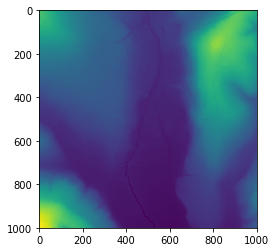

In [4]:
#nlin = 2000
#ncol = 3000
#dem = np.arange(nlin*ncol).reshape(nlin,ncol)
#dem = (np.sin(dem * 0.01) + np.random.rand(nlin,ncol))
#dem = np.minimum(dem, 50)
#print(dem.min(), dem.max(), dem.mean())
#plt.imshow(dem)
#print(np.histogram(dem))

dem = io.imread("/home/klemen/_repo_RVT/RVT_py/test_data/TM1_564_146.tif")

print(dem.min(),dem.max())
plt.imshow(dem)
plt.show()

In [5]:
tic = time.time()
orig = sky_view_factor(dem, 1, compute_svf=True, compute_opns=False, compute_asvf=False,
                    svf_n_dir=32, svf_r_max=10, svf_noise=0, asvf_dir=315, asvf_level=1)
toc = time.time()
print(toc-tic)

4.476556301116943


In [6]:
def horizon_shift_vector(num_directions=16, 
                         radius_pixels=10, 
                         min_radius=1,
                         ):
    
    # Initialize the output dict
    shift = {}

    # Generate angles and corresponding normal shifts in X (columns)
    # and Y (lines) direction
    angles = (2 * np.pi / num_directions) * np.arange(num_directions) 
    x = np.cos(angles)
    y = np.sin(angles)
    angles = np.round(np.degrees(angles), decimals=1)
    
    # Generate a range of radius values in pixels.
    # Make it finer for the selcted scaling.
    # By adding the last constant we make sure that we do not start with
    # point (0,0).
    scale = 3.
    radii = np.arange(radius_pixels*scale-scale+1) / scale + min_radius

    # For each direction compute all possible horizont point position
    # and round them to integers
    for i in range(num_directions):
        x_int = np.round(x[i] * radii, decimals=0)
        y_int = np.round(y[i] * radii, decimals=0)
        # consider only the minimal number of points
        # use the trick with set and complex nuber as the input
        coord_complex = set(x_int + 1j * y_int)
        # to sort proportional with increasing radius, 
        # set has to be converted to numpy array
        shift_pairs = np.array([(k.real, k.imag) for k in coord_complex]).astype(int)
        distance = np.sqrt(np.sum(shift_pairs**2, axis=1))
        sort_index = np.argsort(distance)
        # write for each direction shifts and corresponding distances
        shift[angles[i]] = {
            "shift": [(k[0],k[1]) for k in shift_pairs[sort_index]],
            "distance": distance[sort_index],
            }

    return shift

In [7]:
a=horizon_shift_vector(8, 10, 1)
for i in a.keys():
    print(f"angle {i}")
    for j in a[i]:
        print(f"{j}: {a[i][j]}")

angle 0.0
shift: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)]
distance: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
angle 45.0
shift: [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]
distance: [1.41421356 2.82842712 4.24264069 5.65685425 7.07106781 8.48528137
 9.89949494]
angle 90.0
shift: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10)]
distance: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
angle 135.0
shift: [(-1, 1), (-2, 2), (-3, 3), (-4, 4), (-5, 5), (-6, 6), (-7, 7)]
distance: [1.41421356 2.82842712 4.24264069 5.65685425 7.07106781 8.48528137
 9.89949494]
angle 180.0
shift: [(-1, 0), (-2, 0), (-3, 0), (-4, 0), (-5, 0), (-6, 0), (-7, 0), (-8, 0), (-9, 0), (-10, 0)]
distance: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
angle 225.0
shift: [(-1, -1), (-2, -2), (-3, -3), (-4, -4), (-5, -5), (-6, -6), (-7, -7)]
distance: [1.41421356 2.82842712 4.24264069 5.65685425 7.07106781 8.48528137
 9.89949494]
angle 270.0
shif

In [8]:
sky_view_det_move(8, 10, 1000)

array([[[-1.0000000e+03, -9.9900000e+02,  1.0000000e+00,  1.0010000e+03,
          1.0000000e+03,  9.9900000e+02, -1.0000000e+00, -1.0010000e+03],
        [-2.0000000e+03, -1.9980000e+03,  2.0000000e+00,  2.0020000e+03,
          2.0000000e+03,  1.9980000e+03, -2.0000000e+00, -2.0020000e+03],
        [-3.0000000e+03, -2.9970000e+03,  3.0000000e+00,  3.0030000e+03,
          3.0000000e+03,  2.9970000e+03, -3.0000000e+00, -3.0030000e+03],
        [-4.0000000e+03, -3.9960000e+03,  4.0000000e+00,  4.0040000e+03,
          4.0000000e+03,  3.9960000e+03, -4.0000000e+00, -4.0040000e+03],
        [-5.0000000e+03, -4.9950000e+03,  5.0000000e+00,  5.0050000e+03,
          5.0000000e+03,  4.9950000e+03, -5.0000000e+00, -5.0050000e+03],
        [-6.0000000e+03, -5.9940000e+03,  6.0000000e+00,  6.0060000e+03,
          6.0000000e+03,  5.9940000e+03, -6.0000000e+00, -6.0060000e+03],
        [-7.0000000e+03, -6.9930000e+03,  7.0000000e+00,  7.0070000e+03,
          7.0000000e+03,  6.9930000e+03, -7.0

In [15]:
def sky_view_factor_com_new(height_arr, 
                            radius_max=10, 
                            radius_min=1, 
                            num_directions=16,
                            compute_svf=True, 
                            compute_opns=False,
                            compute_asvf=False, 
                            #a_main_direction, a_poly_level, a_min_weight,
                            ):

    # increase the array shape for the radius_max on all 4 sides
    height = np.pad(height_arr, radius_max, mode='symmetric')

    # vector of movement
    move = horizon_shift_vector(num_directions=num_directions, radius_pixels=radius_max, min_radius=radius_min)

    # init the outputs
    if compute_svf:
        svf_out = np.zeros(height.shape, dtype=np.float32)
    else:
        svf_out = None
    if compute_asvf:
        asvf_out = np.zeros(height.shape, dtype=np.float32)
    else:
        asvf_out = None
    if compute_opns:
        opns_out = np.zeros(height.shape, dtype=np.float32)
    else:
        opns_out = None 

    #if compute_asvf:
    #    asvf_out = np.zeros(count_height, dtype=np.float32)
    #    w_m = a_min_weight  # compute weights
    #    w_a = np.deg2rad(a_main_direction)
    #    weight = np.arange(num_directions) * dir_step
    #    weight = (1 - w_m) * (np.cos((weight - w_a) / 2)) ** a_poly_level + w_m

    # look into each direction...
    for direction in move:
        # reset maximum at each iteration - at each new direction
        max_slope = np.zeros(height.shape, dtype=np.float32) - 1000

        # ... and to the search radius
        for i, radius in enumerate(move[direction]["distance"]):
            # get shift index from move dictionary
            shift_indx = move[direction]["shift"][i]
            # estimate the slope
            _ = (np.roll(height, shift_indx, axis=(0,1)) - height) / radius
            # compare to the previus max slope and keep the larges
            max_slope = np.maximum(max_slope, _)
        
        # convert to angle in radians and compute directional output
        _ = np.arctan(max_slope)
        if compute_svf:
            svf_out = svf_out + (1 - np.sin(np.maximum(_,0)))
        if compute_opns:
            opns_out = opns_out + _

    # cut to original extent and 
    # average the directional output over all directions
    if compute_svf:
        svf_out = svf_out[radius_max:-radius_max, radius_max:-radius_max] / num_directions
    # if compute_asvf:
    #     asvf_out = asvf_out / np.sum(weight)
    if compute_opns:
        opns_out = 0.5 * np.pi - (opns_out[radius_max:-radius_max, radius_max:-radius_max] / num_directions)

    dict_svf_asvf_opns = {"svf": svf_out, "asvf": asvf_out, "opns": opns_out}
    dict_svf_asvf_opns = {k: v for k, v in dict_svf_asvf_opns.items() if v is not None}  # filter out none

    return dict_svf_asvf_opns

In [21]:
tic = time.time()
new = sky_view_factor_com_new(dem, 
                            radius_max=10, 
                            radius_min=1, 
                            num_directions=32,
                            compute_svf=True,
                            compute_opns=True)

toc = time.time()
print(toc-tic)

2.965413808822632


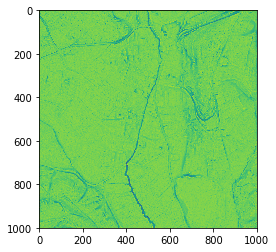

In [22]:
plt.imshow(new["opns"])


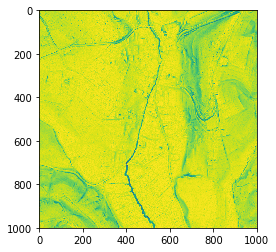

In [134]:
plt.imshow(orig["svf"])

In [20]:
print(np.mean(np.abs(new["svf"]-orig["svf"])))

0.0029739311
